In [60]:
#hide
!pip3 install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
im3_path = threes[3]
im3 = Image.open(im3_path)
im3

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 178],
       [  0,   0,   0,   0,   0, 186],
       [  0,   0,   0,   0,   0, 186],
       [  0,   0,   0,   0,   0,  39]], dtype=uint8)

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 178],
        [  0,   0,   0,   0,   0, 186],
        [  0,   0,   0,   0,   0, 186],
        [  0,   0,   0,   0,   0,  39]], dtype=torch.uint8)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,104,253,253,253,255,253,253,253,218,32,0,0
2,0,0,0,0,0,178,248,252,252,252,253,252,252,252,252,215,34,0
3,0,0,0,0,0,186,252,252,252,252,253,252,252,252,252,252,79,0
4,0,0,0,0,0,186,252,243,172,172,39,39,39,219,252,252,79,0
5,0,0,0,0,0,39,53,47,0,0,0,29,117,244,252,252,79,0
6,0,0,0,0,0,0,0,0,0,0,54,208,252,252,252,184,21,0
7,0,0,0,0,0,0,0,0,3,41,253,252,252,252,206,21,0,0
8,0,0,0,0,0,0,5,41,165,252,253,252,252,252,227,131,9,0
9,0,0,0,0,0,109,163,252,252,252,253,252,252,252,252,252,156,0


Question: How might you got about getting a computer to recognize 3 or a 7?
- a computer can learn where the pixel values are located for a 7 vs 3
- could learn form pictures of the numbers where the pixels are located

## First Try: Pixel Similarity

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

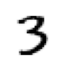

In [15]:
show_image(three_tensors[1]);

In [16]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [25]:
len(stacked_threes.shape)

3

In [26]:
stacked_threes.ndim

3

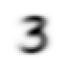

In [17]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

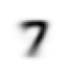

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Question: How would you calculate how similar a particular image is to each of our ideal images?
- Maybe a intersection or union of the matrices to find the difference

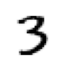

In [19]:
a_3 = stacked_threes[1]
show_image(a_3);

In [20]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [21]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [22]:
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()

(tensor(0.1114), tensor(0.2021))

In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [24]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [25]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
tns[1]

tensor([4, 5, 6])

In [29]:
tns[:,1]

tensor([2, 5])

In [30]:
tns[1,1:3]

tensor([5, 6])

In [31]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [32]:
tns.type()

'torch.LongTensor'

In [33]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [34]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [35]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [39]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1181, 0.1168,  ..., 0.1599, 0.1295, 0.1445]),
 torch.Size([1010]))

In [40]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [41]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [42]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [43]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [44]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [45]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [77]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [46]:
def f(x): return x**2

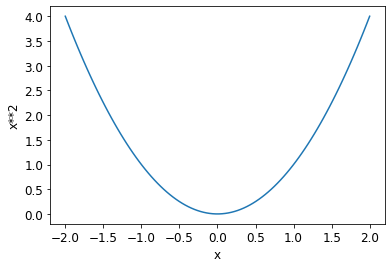

In [48]:
plot_function(f, 'x', 'x**2')

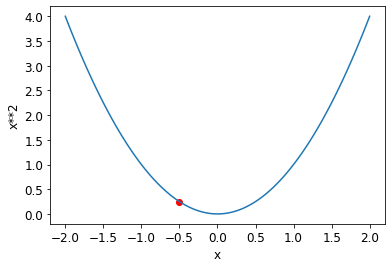

In [49]:
plot_function(f, 'x', 'x**2')
plt.scatter(-.5, f(-.5), color='red');

### Calculating Gradients

In [51]:
xt = tensor(3.).requires_grad_()

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [53]:
yt.backward()

In [56]:
xt.grad

tensor(6.)

In [57]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [58]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [59]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [60]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

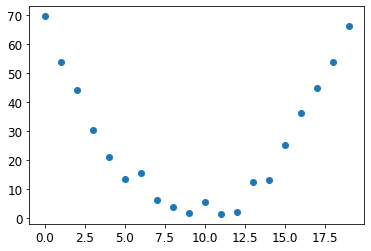

In [64]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [65]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [66]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [67]:
params = torch.randn(3).requires_grad_()

In [68]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [69]:
preds = f(time, params)

In [70]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

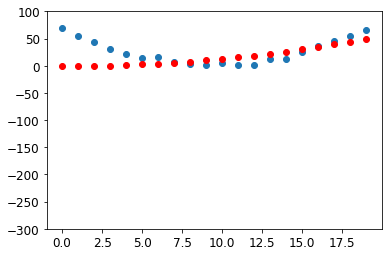

In [71]:
show_preds(preds)

#### Step 3: Calculate the loss

In [72]:
loss = mse(preds, speed)
loss

tensor(634.3897, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [73]:
loss.backward()
params.grad

tensor([-159.3539,  -13.6487,  -19.8015])

In [74]:
params.grad * 1e-5

tensor([-0.0016, -0.0001, -0.0002])

In [75]:
params

tensor([ 0.1498, -0.2089, -0.3870], requires_grad=True)

#### Step 5: Step the weights. 

In [76]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [77]:
preds = f(time,params)
mse(preds, speed)

tensor(634.2023, grad_fn=<MeanBackward0>)

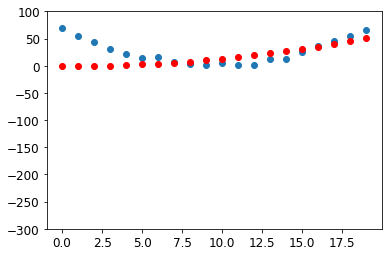

In [78]:
show_preds(preds)

In [79]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [80]:
for i in range(10): apply_step(params)

634.2022705078125
634.1636962890625
634.1534423828125
634.1483764648438
634.1444702148438
634.1405639648438
634.1368408203125
634.1329956054688
634.1292724609375
634.1254272460938


In [81]:
#hide
params = orig_params.detach().requires_grad_()

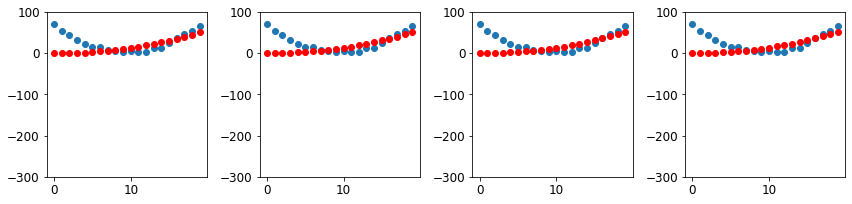

In [82]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [83]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [84]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [89]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [90]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [91]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [92]:
weights = init_params((28*28,1))

In [93]:
bias = init_params(1)

In [94]:
(train_x[0]*weights.T).sum() + bias

tensor([-14.4462], grad_fn=<AddBackward0>)

In [95]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-14.4462],
        [-11.6078],
        [-14.5558],
        ...,
        [  2.3200],
        [-10.5686],
        [  1.4483]], grad_fn=<AddBackward0>)

In [96]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [False]])

In [97]:
corrects.float().mean().item()

0.3976282775402069

In [98]:
weights[0] *= 1.0001

In [99]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.3976282775402069

In [100]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.8])

In [101]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [107]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [105]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [108]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [109]:
def sigmoid(x): return 1/(1+torch.exp(-x))

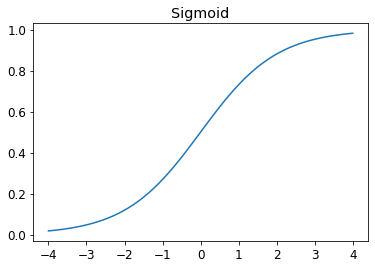

In [110]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [111]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [112]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [113]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [114]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

In [117]:
weights = init_params((28*28,1))
bias = init_params(1)

In [126]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [120]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [121]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [122]:
preds = linear1(batch)
preds

tensor([[ -9.6378],
        [-22.0662],
        [-21.0816],
        [-18.5892]], grad_fn=<AddBackward0>)

In [123]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1.0000, grad_fn=<MeanBackward0>)

In [124]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-2.3282e-06), tensor([-1.6304e-05]))

In [127]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [128]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-4.6565e-06), tensor([-3.2608e-05]))

In [129]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-6.9847e-06), tensor([-4.8912e-05]))

In [130]:
weights.grad.zero_()
bias.grad.zero_();

In [131]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [132]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [133]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [134]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [135]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [136]:
validate_epoch(linear1)

0.3449

In [137]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5614

In [138]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7905 0.8867 0.9252 0.9413 0.9477 0.9526 0.9555 0.9584 0.9623 0.9628 0.9663 0.9678 0.9692 0.9697 0.9707 0.9712 0.9717 0.9726 0.9721 0.9726 

### Creating an Optimizer

In [139]:
linear_model = nn.Linear(28*28,1)

In [140]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [141]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [142]:
opt = BasicOptim(linear_model.parameters(), lr)

In [143]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [144]:
validate_epoch(linear_model)

0.3688

In [145]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [146]:
train_model(linear_model, 20)

0.4932 0.813 0.8438 0.9131 0.9341 0.9478 0.9551 0.9629 0.9653 0.9673 0.9688 0.9712 0.9731 0.9746 0.9756 0.9761 0.9775 0.9775 0.9785 0.9785 

In [147]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.79 0.854 0.917 0.9351 0.9482 0.9575 0.9624 0.9658 0.9678 0.9702 0.9717 0.9736 0.9751 0.9761 0.9766 0.9775 0.978 0.978 0.9785 

In [148]:
dls = DataLoaders(dl, valid_dl)

In [149]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [150]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636685,0.503584,0.495584,00:00
1,0.561653,0.138428,0.905299,00:00
2,0.204190,0.209660,0.803729,00:00
3,0.088708,0.114995,0.905299,00:00
4,0.046145,0.081653,0.930324,00:00
5,0.029580,0.064515,0.945535,00:00
6,0.022799,0.054042,0.954367,00:00
7,0.019816,0.047160,0.960746,00:00
8,0.018329,0.042384,0.965162,00:00
9,0.017453,0.038903,0.966634,00:00


## Adding a Nonlinearity

In [151]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [152]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

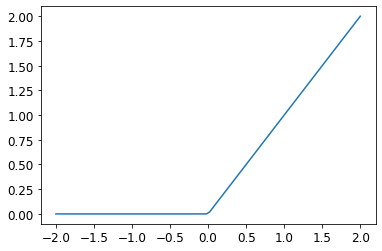

In [153]:
plot_function(F.relu)

In [154]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [155]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [156]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.288236,0.409974,0.505888,00:00
1,0.135897,0.216302,0.817959,00:00
2,0.076273,0.110432,0.917566,00:00
3,0.050894,0.075395,0.943081,00:00
4,0.039075,0.059229,0.958292,00:00
5,0.032988,0.050131,0.964671,00:00
6,0.029451,0.044372,0.966634,00:00
7,0.027125,0.040412,0.968597,00:00
8,0.025435,0.037511,0.969578,00:00
9,0.024119,0.035281,0.971541,00:00


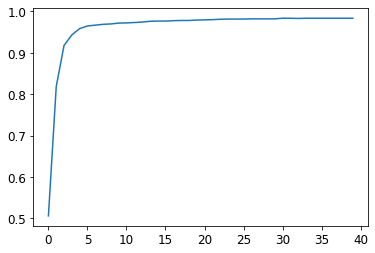

In [157]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [158]:
learn.recorder.values[-1][2]

0.983316957950592

### Going Deeper

In [159]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.191982,0.028071,0.994603,00:07


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

## Questionaire Answers:

1. Images are represented as a matrix of pixel values to the computer

2. There is two folders train and valid which split up the data into images the model will train on and images used to test against the model for accuracy 

3. The pixel similarity approach works by stacking of all the images of 3s and 7s on top of each other, taking the mean of their pixel values in each position to come up with a new image of what the ideal 3 and ideal 7 looks like. Then you can measure how far an image of a 3 or 7 is away from the ideal 3 or 7

4. List comprehension is a feature of python for creting lists in place.

[num*2 for num in numbers if (num%2)==0]

5. A three dimensional tensor? When we stack all of our 3 images on top of eachother we get a rank 3 tensor [6131, 28, 28]

6. The length of a tensors shape is its rank. The shape tells you the length of each axis of the tensor

7. L1 norm is the mean absolute difference 
    (a_3 - mean3).abs().mean()
   
   RMSE or L2 norm is the root mean squared error
   ((a_3 - mean3)**2).mean().sqrt()
   
8. Through the use of broadcasting

In [31]:
# 9
tns = tensor([1,2,3],[4,5,6],[7,8,9])
tns = tns.float()
tns = tns*2
tns[:,2]

tensor([ 6., 12., 18.])

10. broadcasting is a feature of pytorch that makes it so you don't have to run slow for loops in python. It will run on the GPU or optimized C. It also has a unique feature that will match sizes for you. 

11. Metrics are usually calculating using the validation set because if you use training then you won't be able to tell if your model is just memorizing the data

12. SGD is the process of initializing random weights, getting predicitons from our model, based on the predicions calculate the loss, calculate the gradient which measures for each weight how changing the weight would change the loss (derivative), step and update the weights, repeat

13. So that we are not passing our entire dataset to the gpu at once, this would take a very long time and also we are not just passing one data point to the gpu

14. refer to 12

15. By using random values

16. Loss is, based on the predictions from the model, how good were those predictions. Measures the effectiveness of our models performance. Low loss is good and large loss is bad

17. Using a high learning rate can result in taking too large of steps and could take longer or we may not get our weights to where they need to be

18. Gradient is the derivative and tells us how changing the weight will change the loss

19. No, pytorch will do it for you. You should probably know how tho

20. A small change in the value of a weight may not change the accuracy at all, most of the time the gradients will be 0 and the model will not be able to learn from that number

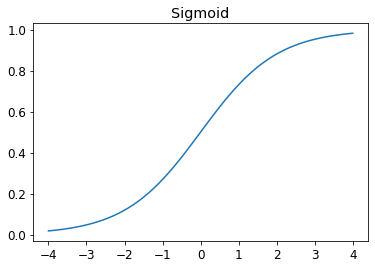

In [41]:
#21
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)
# Whats special about its shape is it is a smooth slope, and all negative 
# will never plot to negative, and all large numbers will never be 
# above 1

22. A metric is the number we care about such as accuracy, the loss function measures how far our predictions are away from the desired output

23. w -= gradient(w) * lr

24. Dataloader can take any collection and turn it into an iterator over many batches, while shuffling the data, it is created from a dataset

25. init_params - not in each epoch but to start
    preds = model(x)
    loss = mse(x, y)
    loss.backward()
    p in params: p.data -= p.grad*lr
    params.grad.zero()

In [59]:
#26
def num_26(preds, trgts):
    merged_list = [(preds[i], trgts[i]) for i in range(0, len(preds))]
    return merged_list
test = num_26([1,2,3,4], 'abcd')
test
# what is special is that its a list of tuple, we can organize our data so
# 1 maps to a and 2 to b and 3 c to 4 to d

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

27. View reshapes a tensor

28. the bias param is the b in y=w*x + b, 

29. The @ operator does matrix multiplication

30. backward computes the gradients of the loss with respect to the models parameters

31. We have to zero out our gradients because when backward is calls it add to the existing gradients we have, so we need to zero then out for the next pass

32. We pass out dataloader, our model, our optimizer, loss functions, and metrics to learner

33. for i in range(epochs):
        preds = model(x)
        loss = loss(preds, y)
        loss.backward()
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
        

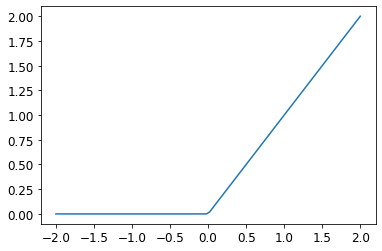

In [61]:
#34. RELU is an activation function, it takes any negatives and makes them 
#0

plot_function(F.relu)

35. Activations are numbers that calculated by both linear and nonlinear layers, an activation function determines the output of the nerual network

36. F.relu is a function and nn.Relu is a class

37. Performance, with a deeper model we don't need as many parameters. We can train the model faster and it will take us less memory

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.